# Analysis of Diencephalon data, merged with Habenula data on E12
The diencephalon dataset (E12.5) are raw counts downloaded from the link included in publication. This dataset needs to be filtered before merging.
The habenula data is already preproccessed, this data will be imported later on and filtered on E12.

The merge is then batch corrected using ComBat, BBKNN, scGEN and Seurat V3. For batch effect correction in Seurat, the filtered diencephalon dataset and the habenula dataset are exported to Seurat. After batch effect correction the object is transformed to a .h5ad file for plotting.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import scanpy.external as sce
import bbknn
import mnnpy as mnn
import scgen
import matplotlib.pyplot as plt
import matplotlib as mpl

#settings
sc.settings.verbosity = 3             # show: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.figdir = "../../../figures/MergedIntegration/SimpleMerge/"
sc.settings.set_figure_params(dpi=80)

C:\Users\Juliska\Anaconda3\envs\UMCU\lib\site-packages\anndata\_core\anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Using TensorFlow backend.


scanpy==1.4.6 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.1 scikit-learn==0.22.1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [2]:
c_cont_red = mpl.colors.LinearSegmentedColormap.from_list('custom_red', 
                                             [(0, 'silver'),
                                              (0.1, (1, 0.82, 0.82)),
                                              (0.2, (1, 0.67, 0.67)),
                                              (0.3, (1, 0.58, 0.58)),
                                              (0.4, (1, 0.48, 0.48)),
                                              (0.5, (1, 0.38, 0.38)),
                                              (0.6, (1, 0.29, 0.29)),
                                              (0.7, (1, 0.22, 0.22)),
                                              (0.8, (1, 0.15, 0.15)),
                                              (0.9, (0.67, 0.09, 0.09)),
                                              (1, (0.54, 0, 0))], N=128)
c_cont_green = mpl.colors.LinearSegmentedColormap.from_list('custom_green', 
                                             [(0, 'silver'),
                                              (0.1, (0.50, 0.93, 0.60)),
                                              (0.2, (0.4, 0.89, 0.5)),
                                              (0.3, (0.3, 0.81, 0.4)),
                                              (0.4, (0.2, 0.73, 0.3)),
                                              (0.5, (0.1, 0.69, 0.2)),
                                              (0.6, (0, 0.62, 0.185)),
                                              (0.7, (0, 0.55, 0.16)),
                                              (0.8, (0, 0.47, 0.15)),
                                              (0.9, (0, 0.36, 0.11)),
                                              (1, (0, 0.29, 0.06))], N=128)
c_cont_blue = mpl.colors.LinearSegmentedColormap.from_list('custom_blue', 
                                             [(0, 'silver'),
                                              (0.1, (0.67, 0.77, 1)),
                                              (0.2, (0.58, 0.68, 1)),
                                              (0.3, (0.48, 0.58, 1)),
                                              (0.4, (0.38, 0.48, 1)),
                                              (0.5, (0.29, 0.39, 1)),
                                              (0.6, (0.22, 0.32, 1)),
                                              (0.7, (0.15, 0.25, 1)),
                                              (0.8, (0.09, 0.19, 1)),
                                              (0.9, (0, 0.1, 0.75)),
                                              (1, (0, 0.1, 0.5))], N=128)

Import datasets.

In [5]:
test = sc.read("../../../data/input/diencephalon_guo_counts.txt").T

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [6]:
adata = test

In [7]:
adata

AnnData object with n_obs × n_vars = 7365 × 22050 

In [8]:
sc.pp.filter_cells(adata, min_genes=0) #calculate the number of genes
adata.obs['n_counts'] = adata.X.sum(axis=1) #calculate the number of counts per cell

normalizing counts per cell
    finished (0:00:01)


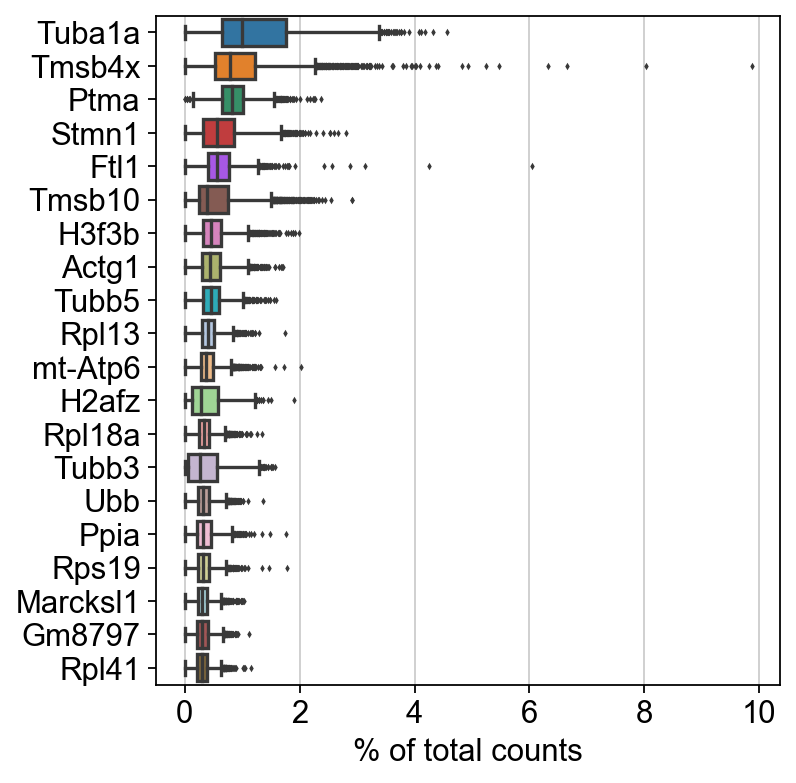

In [9]:
sc.pl.highest_expr_genes(adata, n_top=20)

Show the properties of the data before filtering.

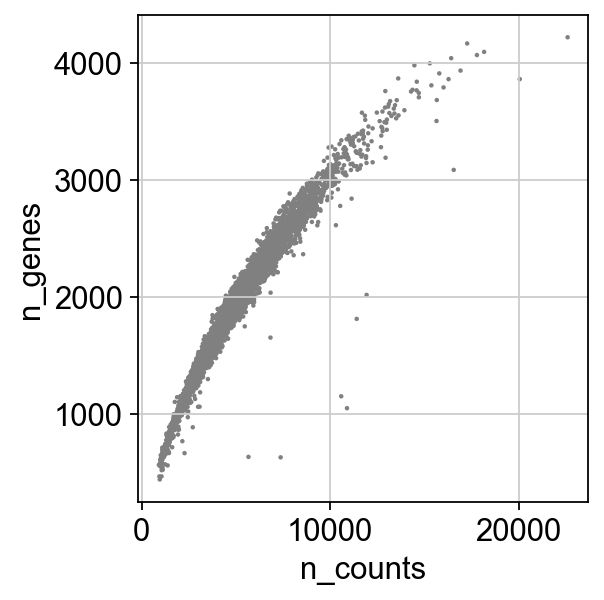

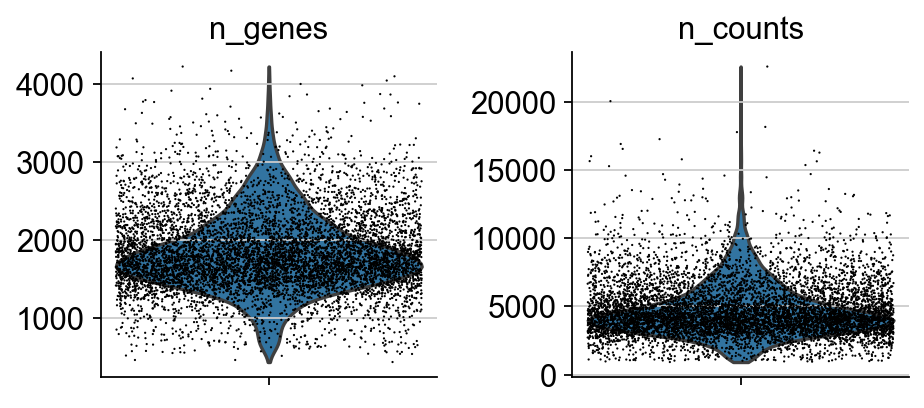

In [10]:
sc.pl.scatter(adata, x='n_counts', y='n_genes')
sc.pl.violin(adata, ['n_genes', 'n_counts'], jitter=0.4, multi_panel=True)

Filter the data. Remove all cells that have less than 2.000 transcripts and more that 50.000, and remove all genes that are expressed in less than 3 cells.

In [11]:
sc.pp.filter_cells(adata, min_genes=2000)
sc.pp.filter_genes(adata, min_cells=3)
adata = adata[adata.obs['n_counts'] < 50000, :]
adata

filtered out 5159 cells that have less than 2000 genes expressed
filtered out 8063 genes that are detected in less than 3 cells


View of AnnData object with n_obs × n_vars = 2206 × 13987 
    obs: 'n_genes', 'n_counts'
    var: 'n_cells'

Also remove mitochondrial genes.

In [12]:
non_mt = [name for name in adata.var_names if not name.startswith('mt')]
adata = adata[:, non_mt]
adata

View of AnnData object with n_obs × n_vars = 2206 × 13974 
    obs: 'n_genes', 'n_counts'
    var: 'n_cells'

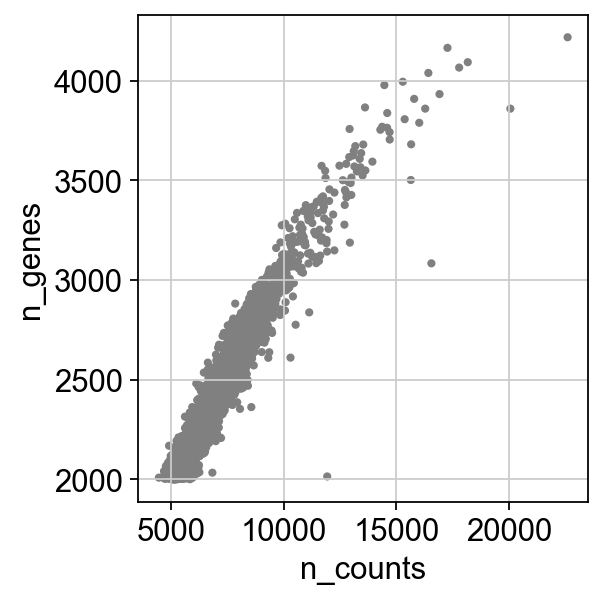

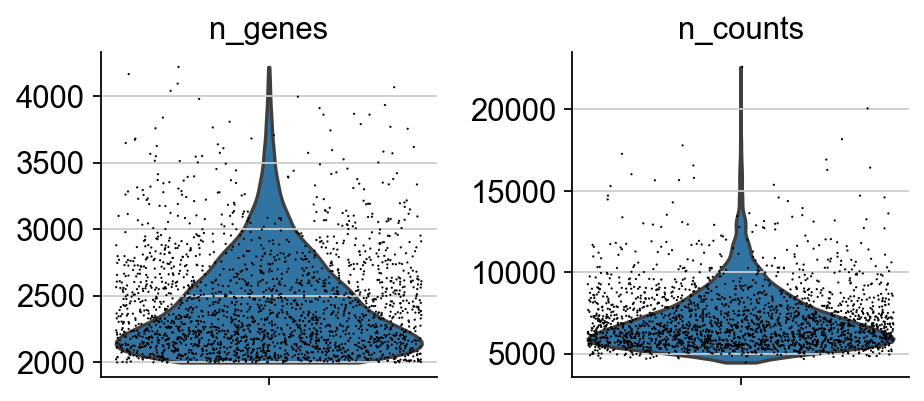

In [13]:
sc.pl.scatter(adata, x='n_counts', y='n_genes')
sc.pl.violin(adata, ['n_genes', 'n_counts'], jitter=0.4, multi_panel=True)

Save the data.

In [14]:
#adata.write('../../../data/output/MergedIntegration/SimpleMerge/Mar2020_merge_diencephalon_filtered_di.h5ad')

## Merging dataset with E12 data
Read the full Habenula dataset, then subset to only E12 cells.

In [15]:
#adatadi = sc.read_h5ad('../../../data/MergedIntegration/SimpleMerge/Mar2020_merge_diencephalon_filtered_di.h5ad')

In [16]:
adata_di = adata.copy()

In [17]:
adata_hb_full = sc.read_h5ad('../../../data/output/DevelopmentalHb/OLD/Mar2020_embryo_Hb_filtered.h5ad')

In [18]:
adata_hb_full

AnnData object with n_obs × n_vars = 3304 × 30452 
    obs: 'n_genes', 'plate', 'platebatch', 'stage', 'well_no', 'ERCC_genes', 'n_total_counts', 'percent_mito', 'n_counts', 'percent_ribo', 'percent_protein_coding', 'percent_lincRNA', 'sum_lincRNA', 'percent_antisense', 'sum_antisense', 'percent_miRNA', 'sum_miRNA', 'percent_bidirectional_promoter_lncRNA', 'sum_bidirectional_promoter_lncRNA', 'percent_snoRNA'
    var: 'ENS_names', 'geneid', 'feature', 'chr', 'fullname', 'n_cells'
    uns: 'plate_colors'
    layers: 'spliced', 'unspliced'

In [19]:
adata_hb = adata_hb_full[adata_hb_full.obs.stage=="E12"]

In [20]:
adata_hb

View of AnnData object with n_obs × n_vars = 270 × 30452 
    obs: 'n_genes', 'plate', 'platebatch', 'stage', 'well_no', 'ERCC_genes', 'n_total_counts', 'percent_mito', 'n_counts', 'percent_ribo', 'percent_protein_coding', 'percent_lincRNA', 'sum_lincRNA', 'percent_antisense', 'sum_antisense', 'percent_miRNA', 'sum_miRNA', 'percent_bidirectional_promoter_lncRNA', 'sum_bidirectional_promoter_lncRNA', 'percent_snoRNA'
    var: 'ENS_names', 'geneid', 'feature', 'chr', 'fullname', 'n_cells'
    uns: 'plate_colors'
    layers: 'spliced', 'unspliced'

First, make sure that both datasets have the same variables and observations. As the Habenula dataset has a lot of annotations, we need to remove them (they are not needed anymore). After that, we can merge the datasets.

In [21]:
rem_obs = ['ERCC_genes', 'n_total_counts', 'plate', 'platebatch', 'stage', 'well_no', 'percent_mito',
                'percent_ribo', 'percent_protein_coding', 'percent_lincRNA', 'sum_lincRNA', 'percent_antisense', 
                 'sum_antisense', 'percent_miRNA', 'sum_miRNA', 'percent_bidirectional_promoter_lncRNA', 
                 'sum_bidirectional_promoter_lncRNA', 'percent_snoRNA']
for item_o in rem_obs:
    del adata_hb.obs[item_o]
    
rem_var = ['ENS_names', 'geneid', 'feature', 'chr', 'fullname']
for item_v in rem_var:
    del adata_hb.var[item_v]

The actual merge. Use join="outer" to keep all genes, not just the ones that the datasets have in common. Transfer all the NaN to 0.0, the NaN are given when e.g. a gene is not present in that dataset.

In [22]:
adata_merge = adata_hb.concatenate(adata_di, join="outer", batch_categories=['Developmental Hb', 'Diencephalon'])

In [23]:
adata_merge

AnnData object with n_obs × n_vars = 2476 × 30864 
    obs: 'batch', 'n_counts', 'n_genes'
    var: 'n_cells-Developmental Hb', 'n_cells-Diencephalon'

In [24]:
adata_merge.uns["batch_colors"] = ["#66c2a5", "#ac8751"]

In [25]:
adata_merge.X = np.nan_to_num(adata_merge.X, nan=0.0)

In [26]:
adata_merge

AnnData object with n_obs × n_vars = 2476 × 30864 
    obs: 'batch', 'n_counts', 'n_genes'
    var: 'n_cells-Developmental Hb', 'n_cells-Diencephalon'
    uns: 'batch_colors'

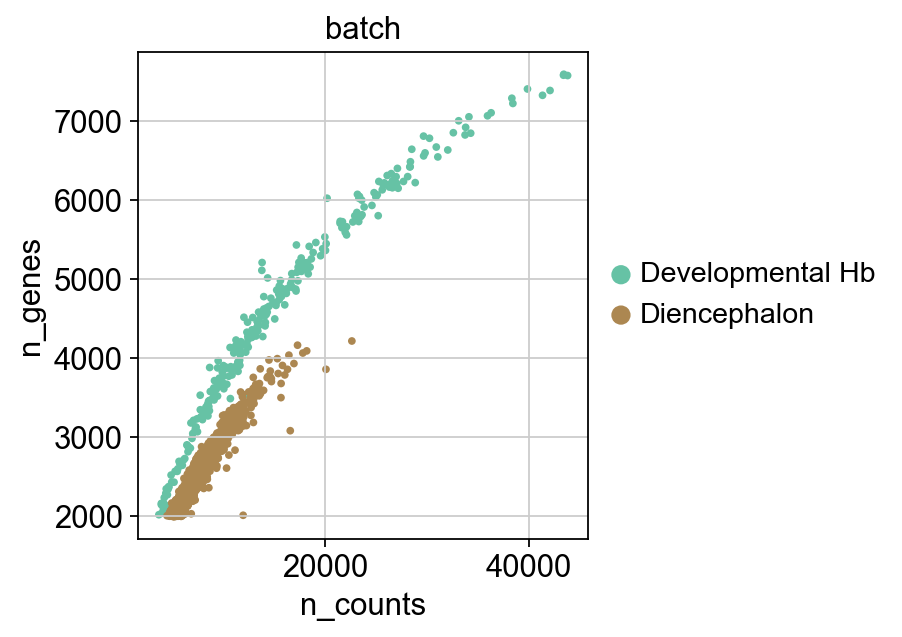

In [27]:
sc.pl.scatter(adata_merge, x='n_counts', y='n_genes', color="batch")

In [28]:
#adata_merge.write('../../../data/output/MergedIntegration/SimpleMerge/Mar2020_merge_diencephalon.h5ad')

Normilization and logtransformation

In [29]:
#adata_merge = sc.read_h5ad('../../../data/output/MergedIntegration/SimpleMerge/Mar2020_merge_diencephalon.h5ad')

In [30]:
sc.pp.normalize_total(adata_merge, key_added='n_counts_norm',layers = 'all')

normalizing counts per cell
    finished (0:00:00)


In [31]:
sc.pp.log1p(adata_merge)

Determine and filter on highly variable genes (HVG)

extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


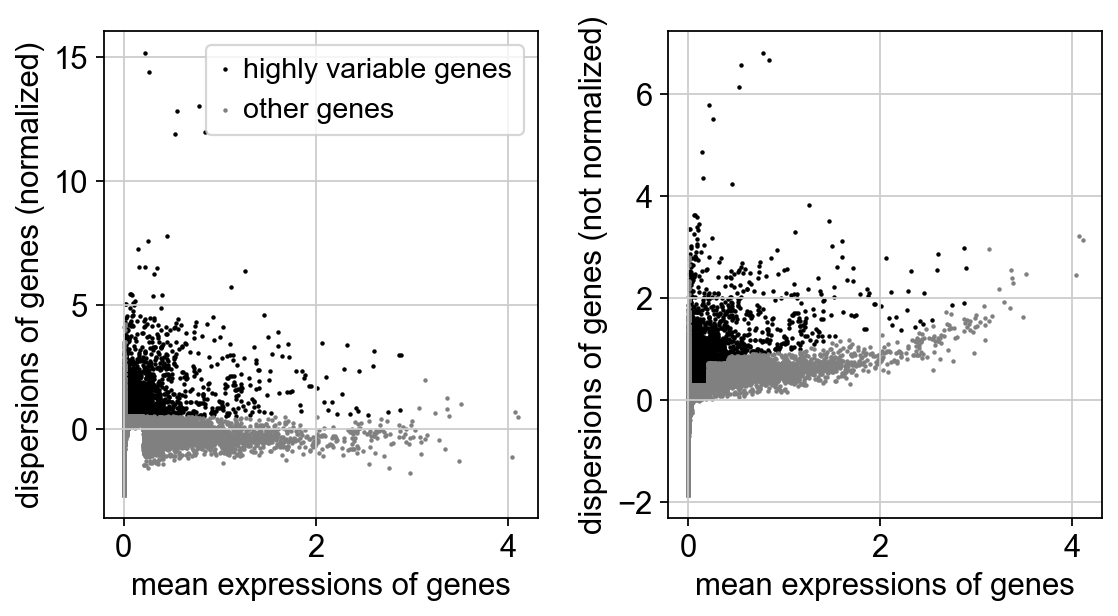

In [32]:
sc.pp.highly_variable_genes(adata_merge, min_mean=0.0125, max_mean=3, min_disp=0.5) ## batch_key = "batch"
sc.pl.highly_variable_genes(adata_merge)

In [33]:
adata_merge = adata_merge[:, adata_merge.var['highly_variable']]
adata_merge

View of AnnData object with n_obs × n_vars = 2476 × 5584 
    obs: 'batch', 'n_counts', 'n_genes', 'n_counts_norm'
    var: 'n_cells-Developmental Hb', 'n_cells-Diencephalon', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'log1p'

Regress out effects of total counts per cell expressed. Scale each gene to unit variance. Clip values exceeding standard deviation 10.

In [34]:
sc.pp.regress_out(adata_merge, 'n_counts')
sc.pp.scale(adata_merge, max_value=10)

regressing out n_counts
    finished (0:00:31)


Saving the normalized data.

In [33]:
#adata_merge.write('../../../data/output/MergedIntegration/SimpleMerge/Mar2020_merge_diencephalon_norm.h5ad')

## Principle component analysis
Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

If you want to run this again with the original data, use the following code where we load adata as the normalized dataset.

In [34]:
#adata_merge = sc.read_h5ad('../../../data/output/MergedIntegration/SimpleMerge/Mar2020_merge_diencephalon_norm.h5ad')

In [35]:
sc.tl.pca(adata_merge, svd_solver='arpack')

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:01)


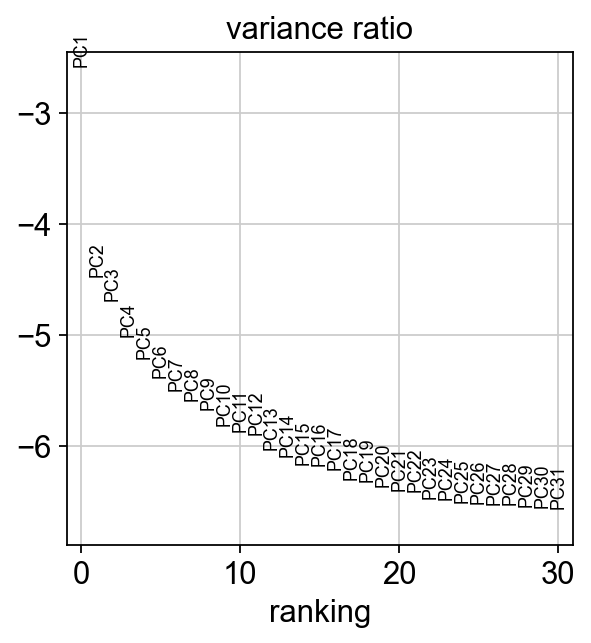

In [36]:
sc.pl.pca_variance_ratio(adata_merge, log=True)

Save the data with the PCs embedded.

In [37]:
#adata_merge.write('../../../data/output/MergedIntegration/SimpleMerge/Mar2020_merge_diencephalon_PCA.h5ad')

## Computing and embedding the neighborhood graph.
In order to compute it, we use the PCA representation of the data matrix.

If you want to run this again with the original data, use the following code where we load adata as the normalized dataset with the PCA representation embedded.

In [38]:
#adata_merge = sc.read_h5ad('../../../data/output/MergedIntegration/SimpleMerge/Mar2020_merge_diencephalon_PCA.h5ad')

In [39]:
sc.pp.neighbors(adata_merge, n_neighbors=10, n_pcs=40) 
## only run this once, if you want to run it again, first load the normalized adata with PCA rep.

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:05)


### Using UMAP

In [40]:
sc.tl.umap(adata_merge) 
## only run this once, if you want to run it again, first load the normalized adata with PCA rep.

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


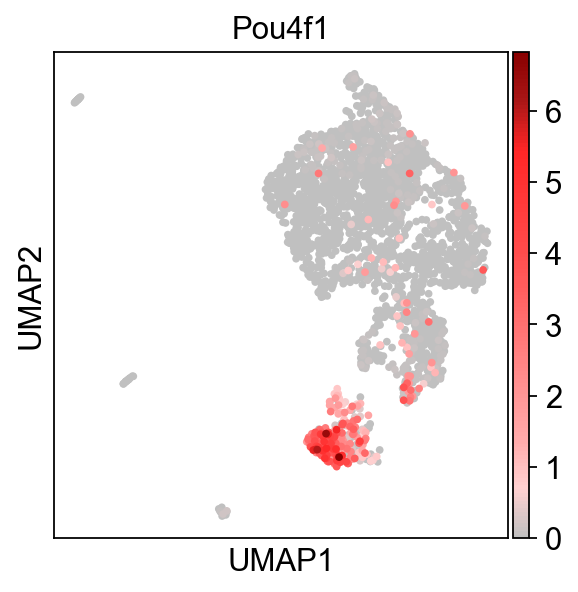

In [41]:
sc.pl.umap(adata_merge, color='Pou4f1', vmin=0, wspace=0.4, save="_Pou4f1_nocorr.pdf", color_map = c_cont_red)

## Clustering of the neighborhood graph
Clustering with louvain. Louvain clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section. 

In [42]:
sc.tl.louvain(adata_merge)
## only run this once, if you want to run it again, first load the data with the neighborhood graph of cells.

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 17 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


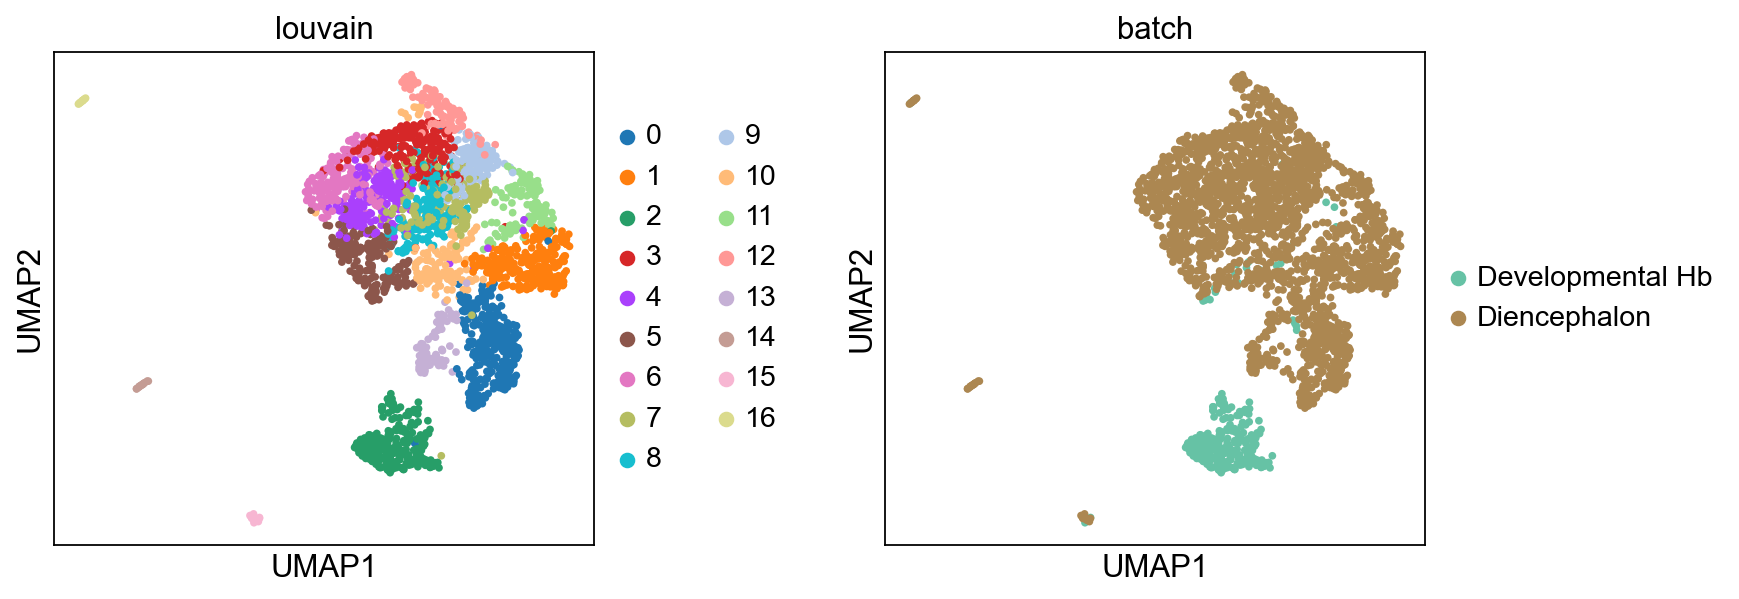

In [43]:
sc.pl.umap(adata_merge, color=['louvain', 'batch'], wspace=0.4, save="_louvain_batch.pdf")

Perform validation. Export metadata and tSNE coordinates to excel files for validation in R.

In [44]:
adata_merge.obs.to_csv("../../../data/output/MergedIntegration/SimpleMerge/BatchTest_raw_metadata.csv")
umap_raw = pd.DataFrame(adata_merge.obsm["X_umap"])
umap_raw.index = adata_merge.obs.index
umap_raw.to_csv("../../../data/output/MergedIntegration/SimpleMerge/BatchTest_raw_umap.csv")

## Batch correction
We perform batch correction using BBKNN, ComBat and scGEN. We validate the correction using batch ARI and batch LISI in R, and we plot Pou4f1+ cells (habenula cells)

Text(0.5, 0, 'Cell')

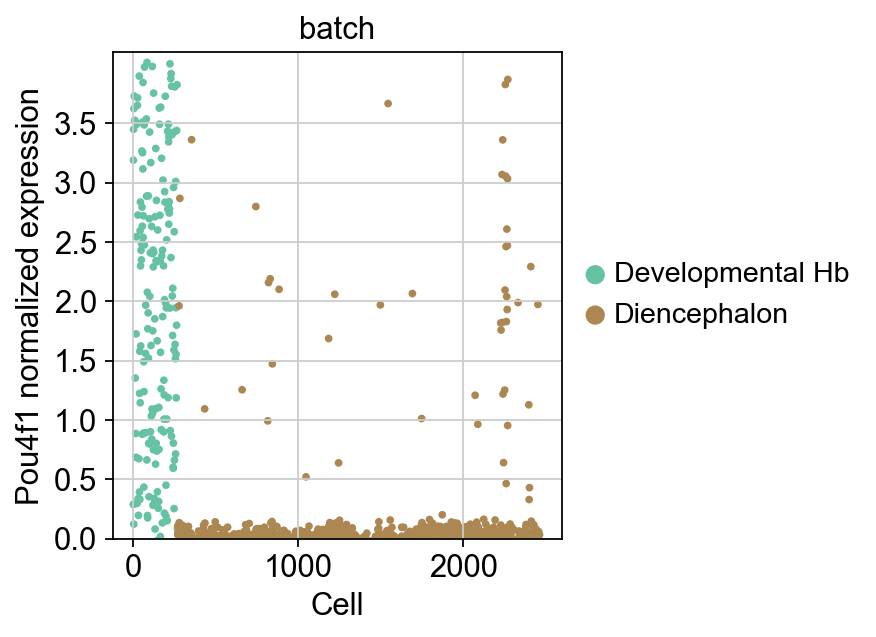

In [35]:
## Determine cut-off score for determining cell_types, first add some observations for plotting.
adata_merge.obs["Pou4f1_norm_expr"] = adata_merge[:, "Pou4f1"].X ## normalized expression of Pou4f1 for each cell
adata_merge.obs["cellnr"] = np.arange(1, len(adata_merge.obs)+1) ## give each cell a number (1 --> #cells)
axes = sc.pl.scatter(adata_merge, x="cellnr", y="Pou4f1_norm_expr", color="batch", show=False)
axes.set_ylim(0, 4.1)
axes.set_yticks(np.arange(0,4,0.5))
axes.set_ylabel("Pou4f1 normalized expression")
axes.set_xlabel("Cell")

In [46]:
## here we use the cut-off we just determined!
sub = adata_merge.obs_vector('Pou4f1') > 0.25
sub = np.where(sub==True, "Pou4f1+", sub) 
sub = np.where(sub=='False', "neuron", sub) 
adata_merge.obs["cell_type"] = sub
adata_merge.uns["cell_type_colors"] = ["red", "lightgrey"]

### Using BBKNN

In [47]:
adata_b = adata_merge.copy()

In [48]:
sc.external.pp.bbknn(adata_b, batch_key="batch")

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix (0:00:03)


In [49]:
#adata_b.write('../../../data/output/MergedIntegration/SimpleMerge/Mar2020_merge_diencephalon_bbknn.h5ad')

In [50]:
#adata_b = sc.read('../../../data/output/MergedIntegration/SimpleMerge/Mar2020_merge_diencephalon_bbknn.h5ad')

Recalculate UMAP coordinates and redo Louvain clustering in order to show the result of the batch correction.

In [51]:
sc.tl.umap(adata_b)
sc.tl.louvain(adata_b)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 15 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


... storing 'cell_type' as categorical


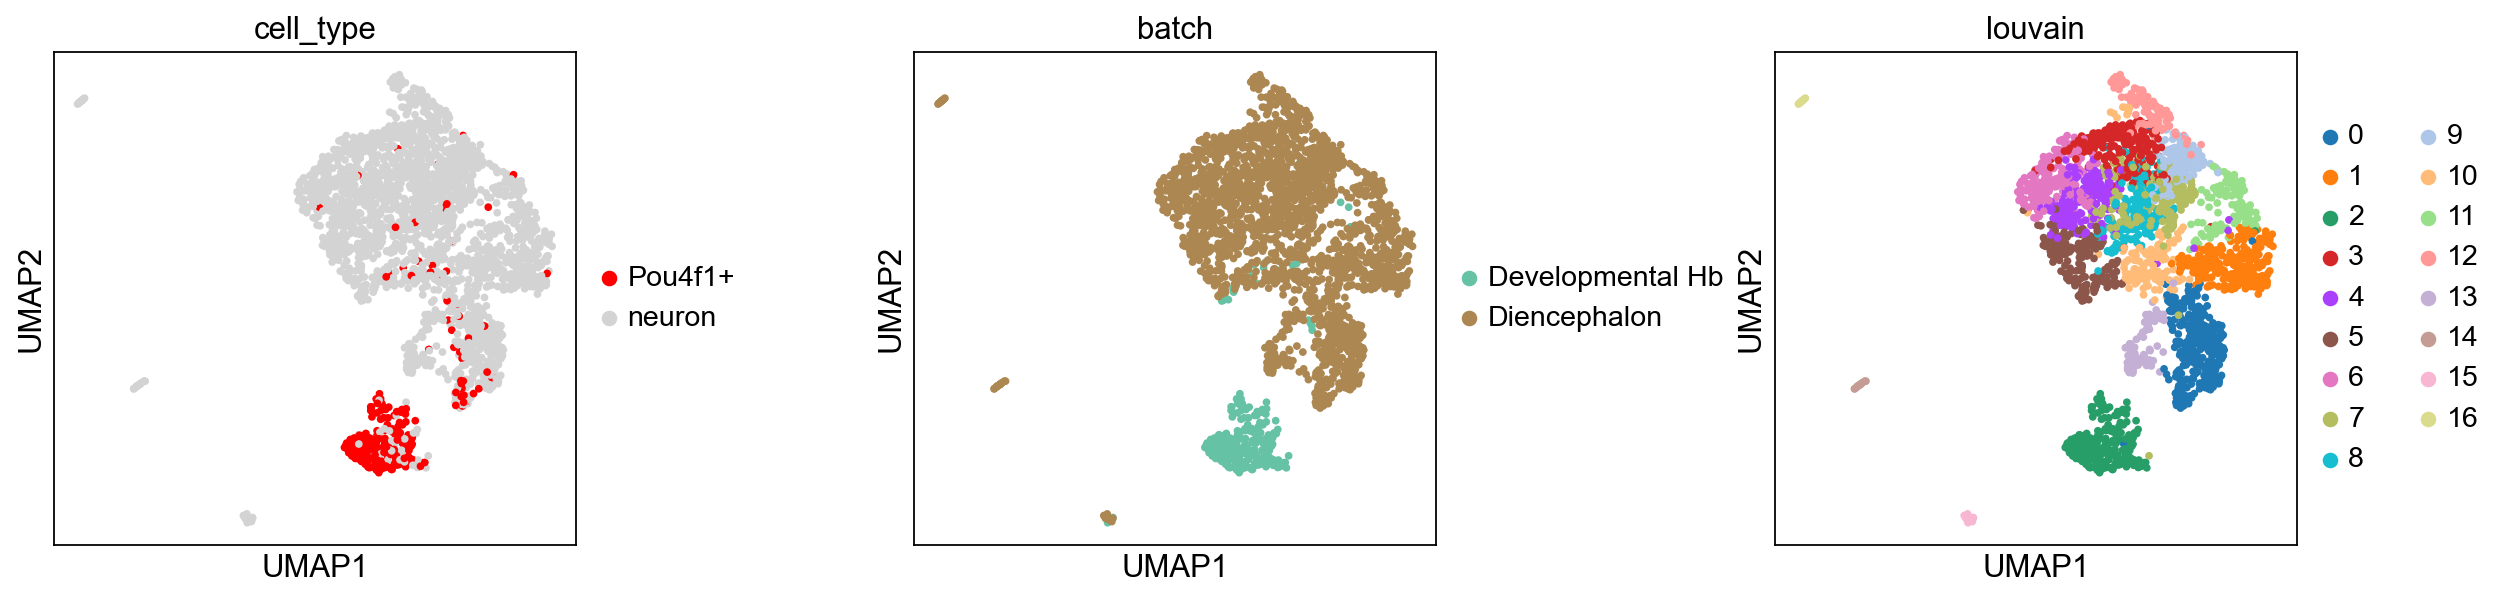

... storing 'cell_type' as categorical


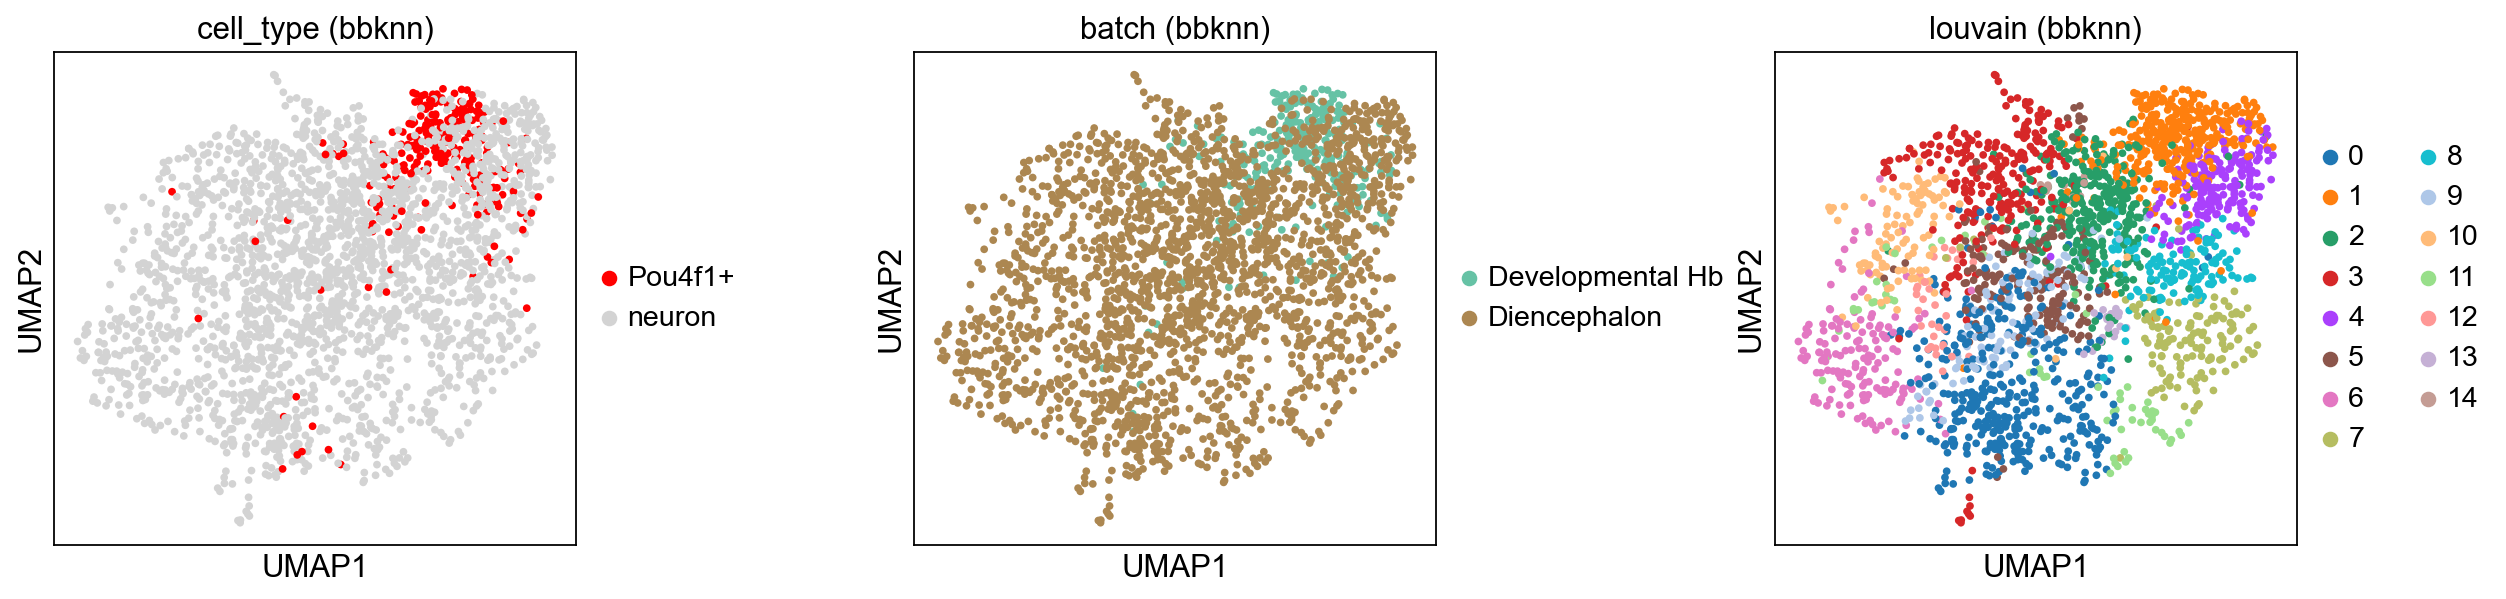

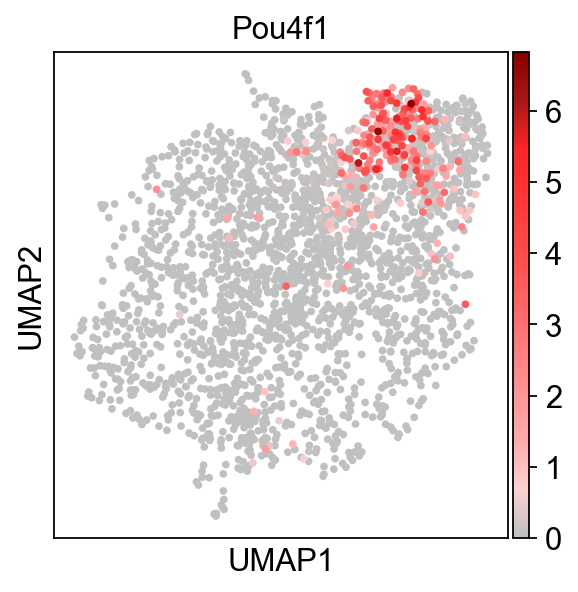

In [52]:
sc.pl.umap(adata_merge, color=['cell_type', 'batch', 'louvain'], wspace=0.5, save="_nocorr.pdf")
sc.pl.umap(adata_b, color=['cell_type', 'batch', 'louvain'], wspace=0.5, save="_bbknn.pdf", title=["cell_type (bbknn)", 
                                                                                                  "batch (bbknn)",
                                                                                                  "louvain (bbknn)"])
sc.pl.umap(adata_b, color='Pou4f1', wspace=0.4, vmin=0, save="_Pou4f1_bbknn.pdf", color_map = c_cont_red)

Perform validation. Export metadata and tSNE coordinates to excel files for validation in R.

In [53]:
adata_b.obs.to_csv("../../../data/output/MergedIntegration/SimpleMerge/BatchTest_BBKNN_metadata.csv")
umap_b = pd.DataFrame(adata_b.obsm["X_umap"])
umap_b.index = adata_b.obs.index
umap_b.to_csv("../../../data/output/MergedIntegration/SimpleMerge/BatchTest_BBKNN_umap.csv")

Show dataset distribution for each cluster

In [54]:
df = pd.DataFrame()
for x in range(0, len(set(adata_b.obs["louvain"]))):
    temp = adata_b[adata_b.obs["louvain"] == str(x)]
    hb = temp[temp.obs["batch"] == "Developmental Hb"].shape[0]
    dienc = temp[temp.obs["batch"] == "Diencephalon"].shape[0]
    perc_hb = (hb/(hb+dienc))*100
    perc_di = (dienc/(hb+dienc))*100
    df[str(x)] = [perc_hb, perc_di]

df.index = ["Developmental Hb", "Diencephalon"]
df = df.add_prefix("Cluster ")

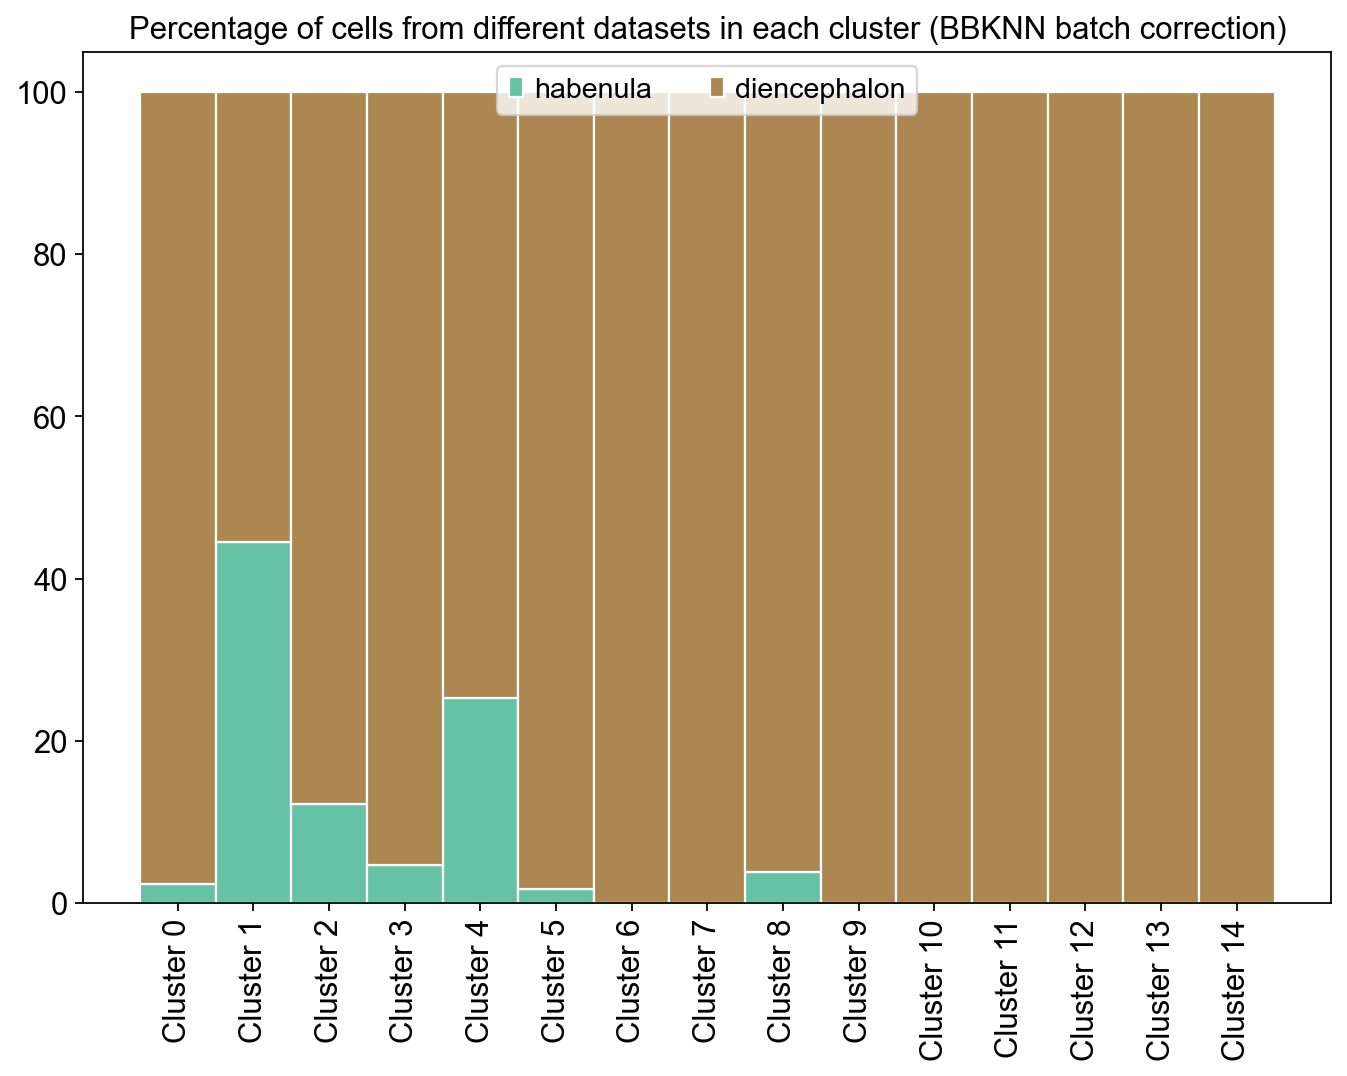

In [55]:
plt.figure(figsize=(10, 7))
een = plt.bar(df.columns, df.loc["Developmental Hb"], edgecolor="white", width=1, color="#66c2a5")
twee = plt.bar(df.columns, df.loc["Diencephalon"], bottom=df.loc["Developmental Hb"], edgecolor="white", width=1, color="#ac8751")
plt.legend((een[0], twee[0]), ("habenula", "diencephalon"), loc="upper center", ncol=2)
plt.xticks(rotation=90)
plt.title("Percentage of cells from different datasets in each cluster (BBKNN batch correction)")
plt.grid(False)
plt.savefig("../../../figures/MergedIntegration/SimpleMerge/cell_distribution_clusters_bbknn.png")
plt.show()

### Using ComBat

In [36]:
adata_c = adata_merge.copy()

In [37]:
sc.pp.combat(adata_c, key='batch', covariates=None, inplace=True)

Standardizing Data across genes.

Found 2 batches

Found 0 numerical variables:
	

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting data



In [38]:
#adata_c.write('../../../data/output/MergedIntegration/SimpleMerge/Mar2020_merge_diencephalon_combat.h5ad')

In [39]:
#adata_c = sc.read('../../../data/output/MergedIntegration/SimpleMerge/Mar2020_merge_diencephalon_combat.h5ad')

In [40]:
sc.tl.pca(adata_c, svd_solver='arpack')
sc.pp.neighbors(adata_c, n_neighbors=10, n_pcs=40) 
sc.tl.umap(adata_c)
sc.tl.louvain(adata_c)

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 15 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


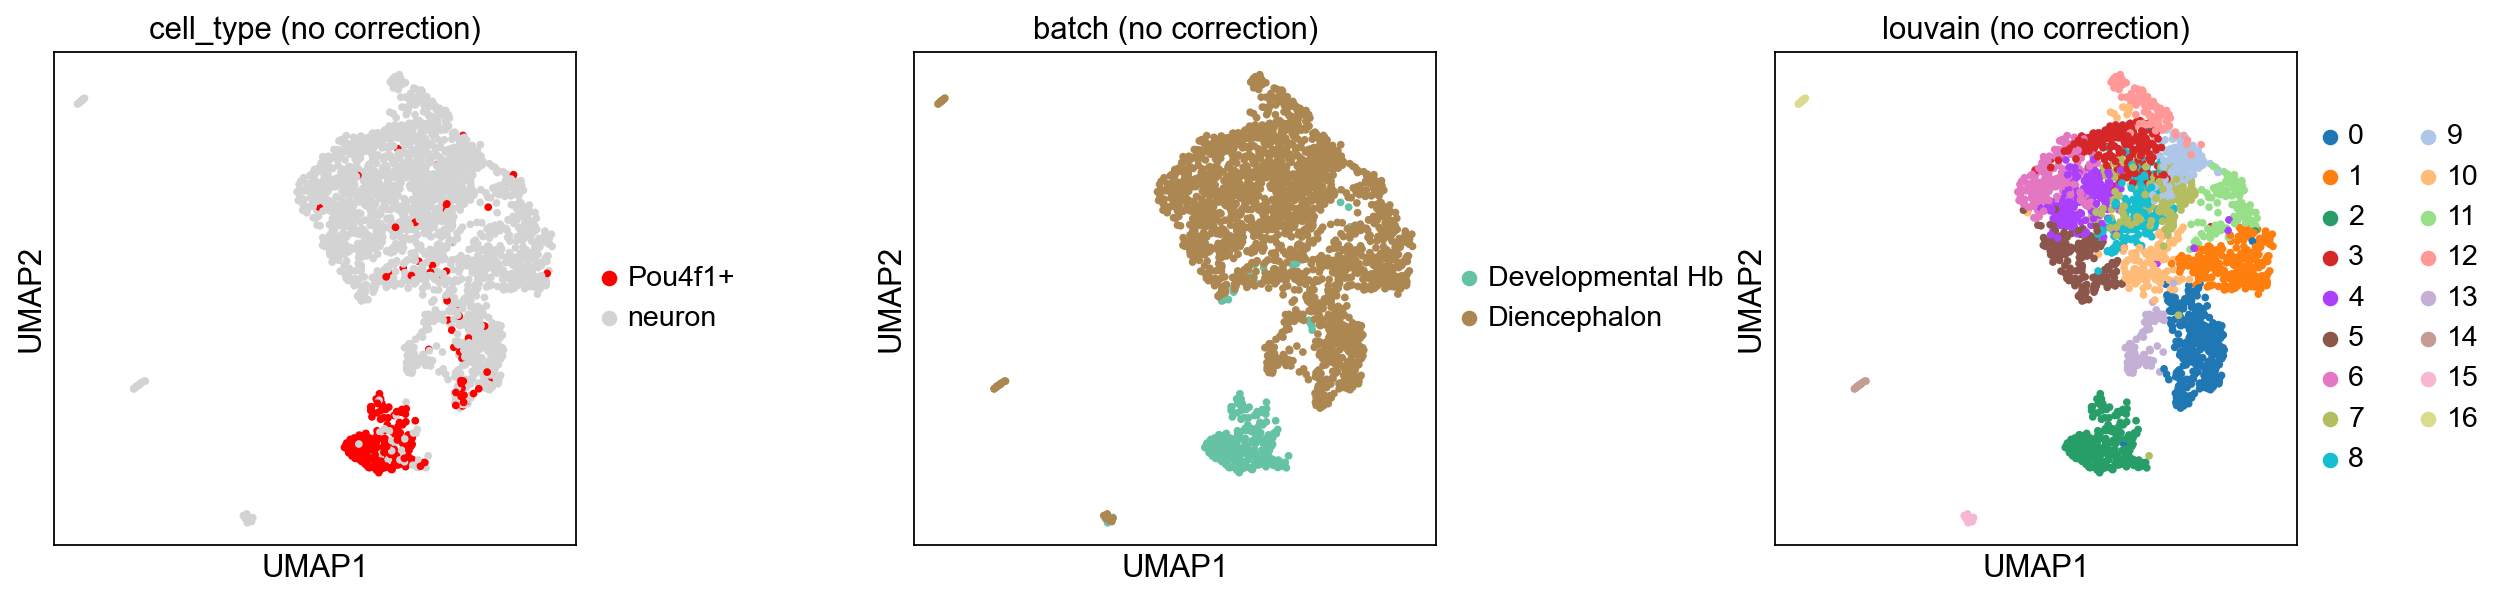

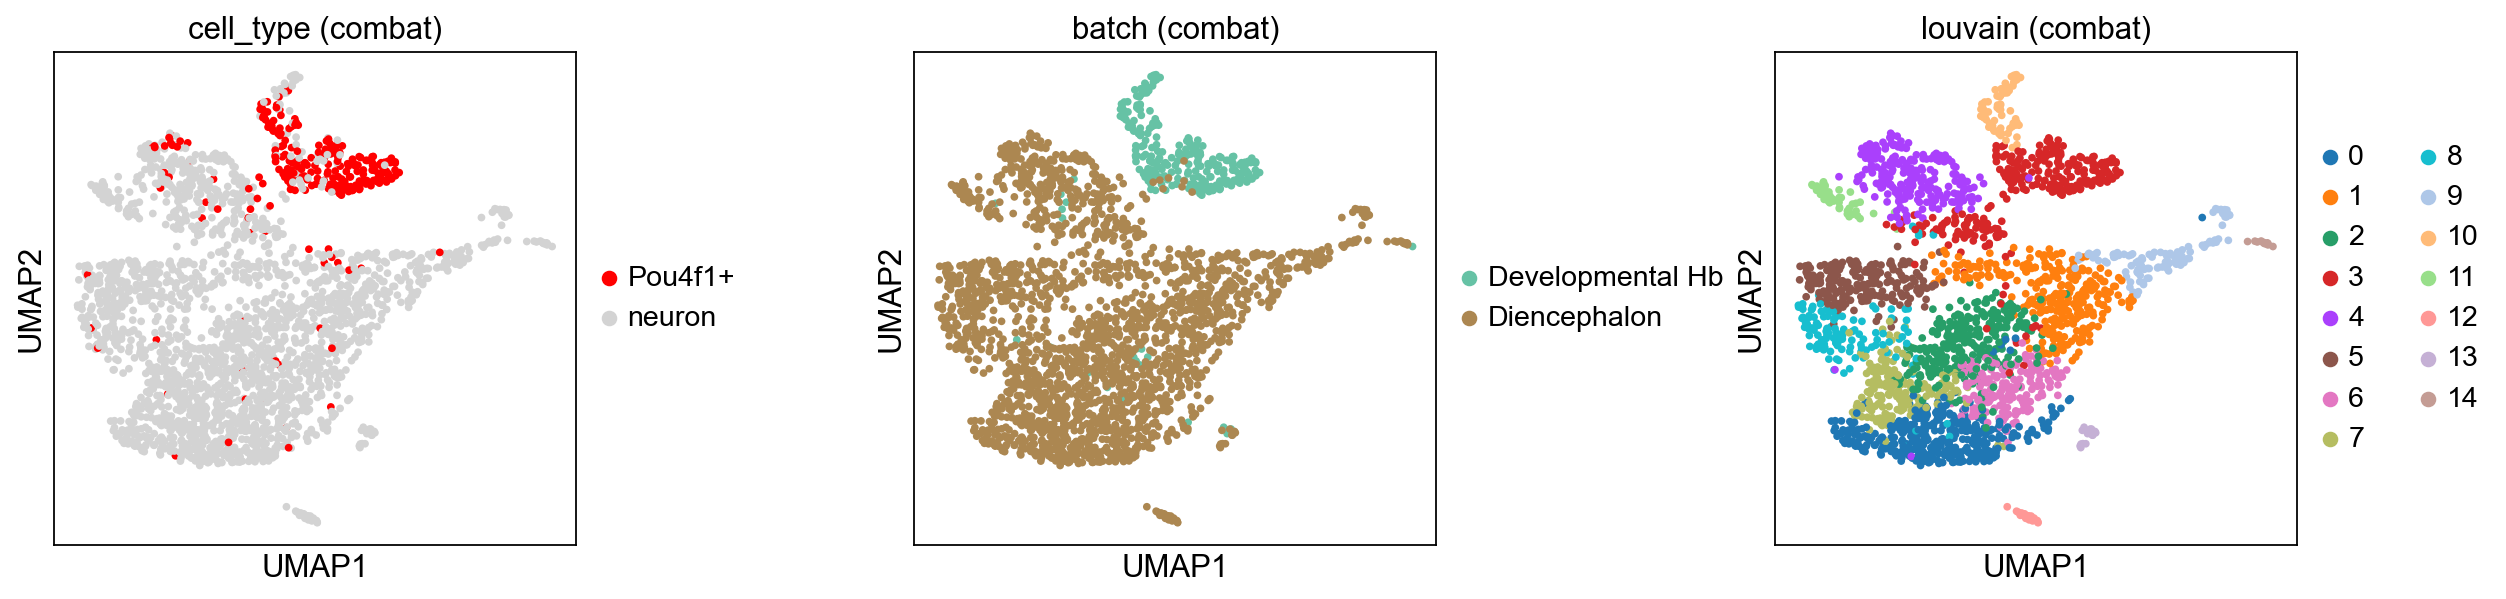

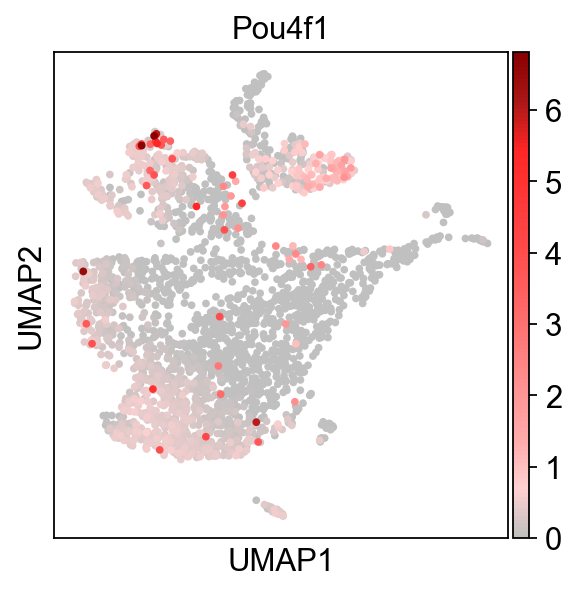

In [61]:
sc.pl.umap(adata_merge, color=['cell_type', 'batch', 'louvain'], wspace=0.5, title=["cell_type (no correction)", 
                                                                                                  "batch (no correction)",
                                                                                                  "louvain (no correction)"])
sc.pl.umap(adata_c, color=['cell_type', 'batch', 'louvain'], wspace=0.5, save="_combat.pdf", title=["cell_type (combat)", 
                                                                                                  "batch (combat)",
                                                                                                  "louvain (combat)"])
sc.pl.umap(adata_c, color='Pou4f1', wspace=0.4, vmin=0, save="_Pou4f1_combat.pdf", color_map = c_cont_red)

Perform validation. Export metadata and tSNE coordinates to excel files for validation in R.

In [41]:
adata_c.obs.to_csv("../../../data/output/MergedIntegration/SimpleMerge/BatchTest_combat_metadata.csv")
umap_c = pd.DataFrame(adata_c.obsm["X_umap"])
umap_c.index = adata_c.obs.index
umap_c.to_csv("../../../data/output/MergedIntegration/SimpleMerge/BatchTest_combat_umap.csv")

Show dataset distribution for each cluster

In [63]:
df = pd.DataFrame()
for x in range(0, len(set(adata_c.obs["louvain"]))):
    temp = adata_b[adata_c.obs["louvain"] == str(x)]
    hb = temp[temp.obs["batch"] == "Developmental Hb"].shape[0]
    dienc = temp[temp.obs["batch"] == "Diencephalon"].shape[0]
    perc_hb = (hb/(hb+dienc))*100
    perc_di = (dienc/(hb+dienc))*100
    df[str(x)] = [perc_hb, perc_di]

df.index = ["Developmental Hb", "Diencephalon"]
df = df.add_prefix("Cluster ")

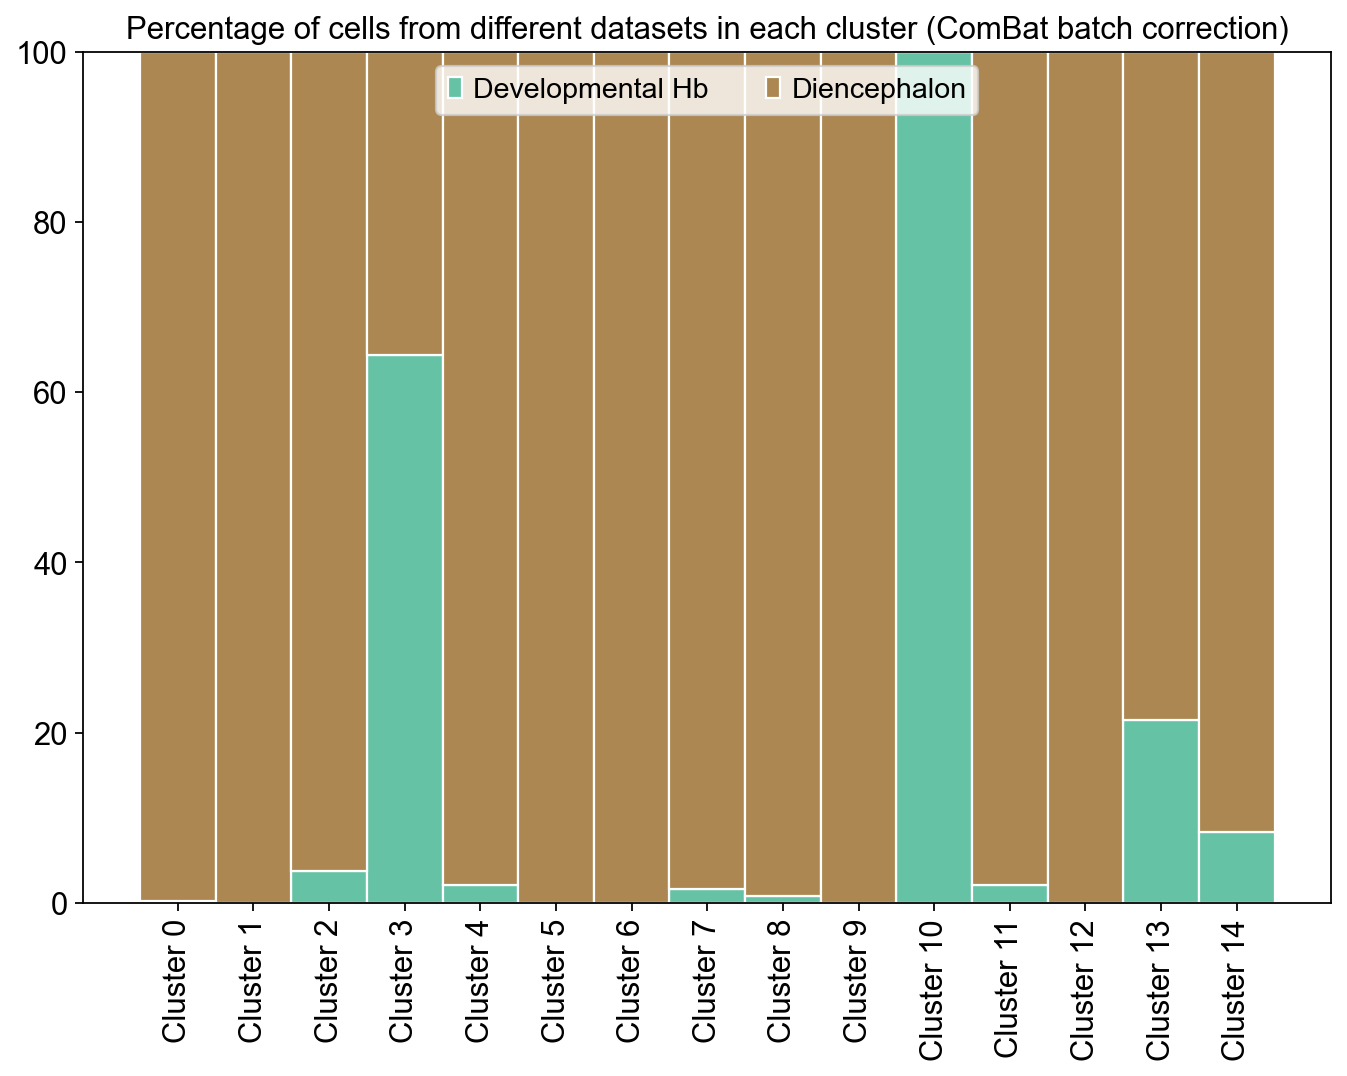

In [64]:
plt.figure(figsize=(10, 7))
een = plt.bar(df.columns, df.loc["Developmental Hb"], edgecolor="white", width=1, color="#66c2a5")
twee = plt.bar(df.columns, df.loc["Diencephalon"], bottom=df.loc["Developmental Hb"], edgecolor="white", width=1, color="#ac8751")
plt.legend((een[0], twee[0]), ("Developmental Hb", "Diencephalon"), loc="upper center", ncol=2)
plt.xticks(rotation=90)
plt.title("Percentage of cells from different datasets in each cluster (ComBat batch correction)")
plt.grid(False)
plt.savefig("../../../figures/MergedIntegration/SimpleMerge/cell_distribution_clusters_combat.png")
plt.show()

### Using scgen
First we create and train a model, which we then will use for batch correction.

In [65]:
adata_n = adata_merge.copy()

In [66]:
network = scgen.VAEArith(x_dimension= adata_n.shape[1], model_path="../../../data/output/MergedIntegration/SimpleMerge/models/batch")
network.train(train_data=adata_n, n_epochs=100)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [67]:
corrected_adata =  scgen.batch_removal(network, adata_n, batch_key="batch", cell_label_key="cell_type")

In [68]:
#corrected_adata.write('../../../data/output/MergedIntegration/SimpleMerge/Mar2020_merge_diencephalon_scgen.h5ad')

In [69]:
#corrected_adata = sc.read('../../../data/output/MergedIntegration/SimpleMerge/Mar2020_merge_diencephalon_scgen.h5ad')

Determine the nearest neighborhood graph, calculate tSNE coordinates (for plotting), cluster the data using louvain clustering.

In [70]:
sc.pp.neighbors(corrected_adata)
sc.tl.umap(corrected_adata)
sc.tl.louvain(corrected_adata)

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA with n_comps = 50
    finished (0:00:00)
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 15 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


In [71]:
corrected_adata.uns["batch_colors"] = ["#66c2a5", "#ac8751"]
corrected_adata.uns["cell_type_colors"] = ["red", "lightgrey"]

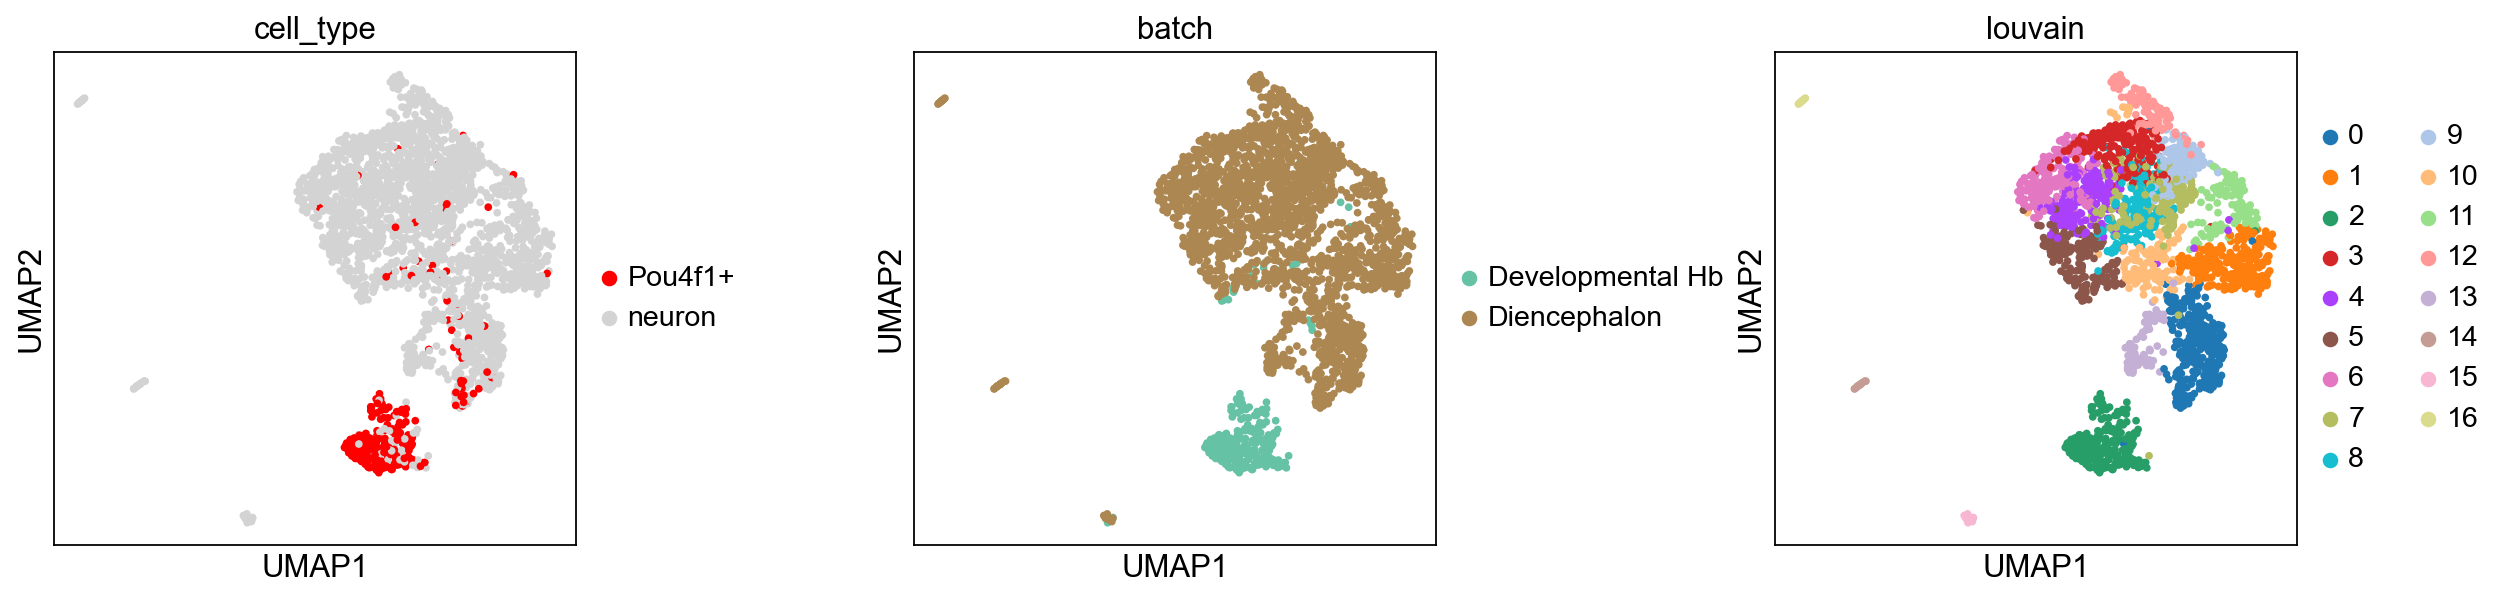

... storing 'cell_type' as categorical


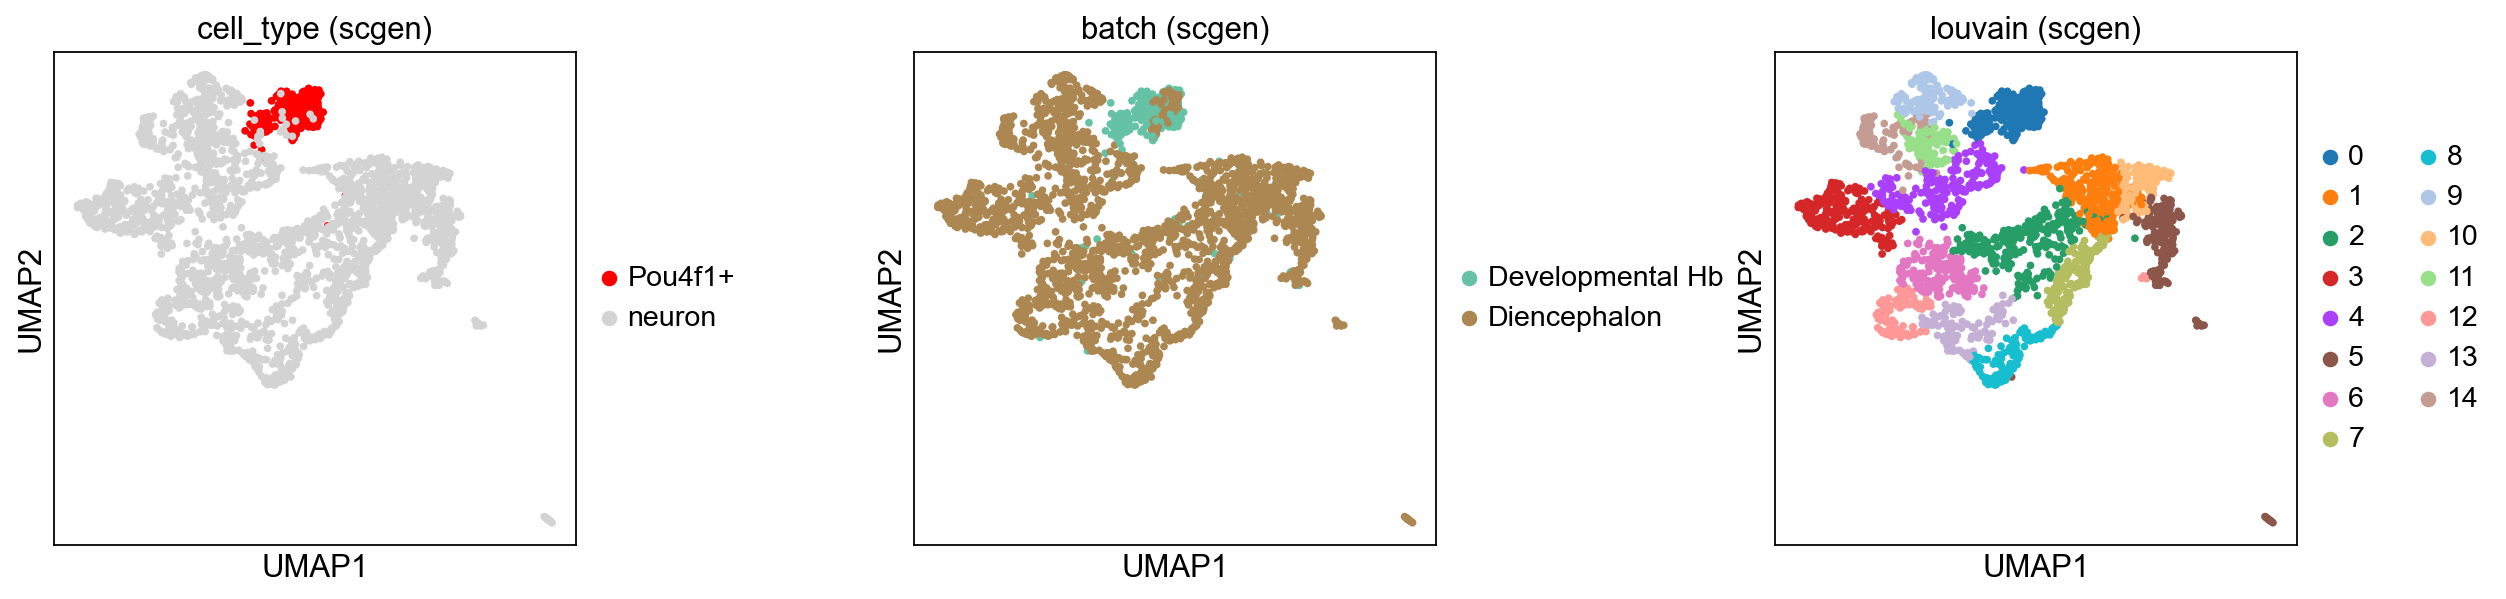

In [72]:
sc.pl.umap(adata_merge, color=['cell_type', 'batch', 'louvain'], wspace=0.5)
sc.pl.umap(corrected_adata, color=['cell_type', 'batch', 'louvain'], wspace=0.5, save="_scgen.pdf", title=["cell_type (scgen)", 
                                                                                                  "batch (scgen)",
                                                                                                  "louvain (scgen)"])

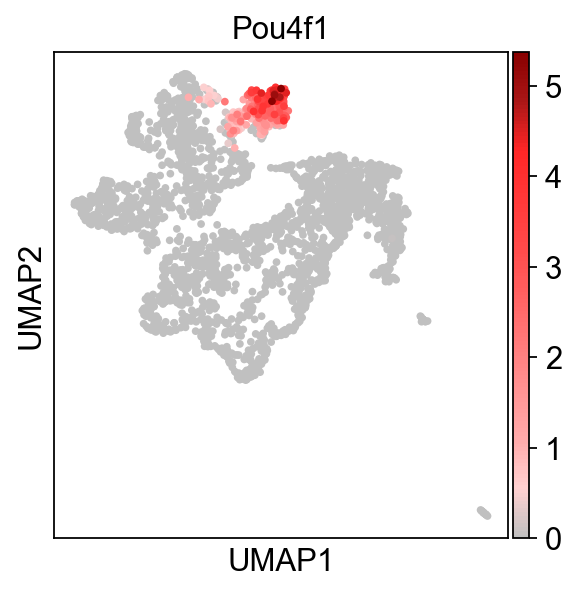

In [73]:
sc.pl.umap(corrected_adata, color='Pou4f1', vmin=0, wspace=0.4,save="_Pou4f1_scgen.pdf", color_map = c_cont_red)

Perform validation. Export metadata and tSNE coordinates to excel files for validation in R.

In [74]:
corrected_adata.obs.to_csv("../../../data/output/MergedIntegration/SimpleMerge/BatchTest_scgen_metadata.csv")
umap_scg = pd.DataFrame(corrected_adata.obsm["X_umap"])
umap_scg.index = corrected_adata.obs.index
umap_scg.to_csv("../../../data/output/MergedIntegration/SimpleMerge/BatchTest_scgen_umap.csv")

Show dataset distribution for each cluster

In [75]:
df = pd.DataFrame()
for x in range(0, len(set(corrected_adata.obs["louvain"]))):
    temp = corrected_adata[corrected_adata.obs["louvain"] == str(x)]
    hb = temp[temp.obs["batch"] == "Developmental Hb"].shape[0]
    dienc = temp[temp.obs["batch"] == "Diencephalon"].shape[0]
    perc_hb = (hb/(hb+dienc))*100
    perc_di = (dienc/(hb+dienc))*100
    df[str(x)] = [perc_hb, perc_di]

df.index = ["Developmental Hb", "Diencephalon"]
df = df.add_prefix("Cluster ")

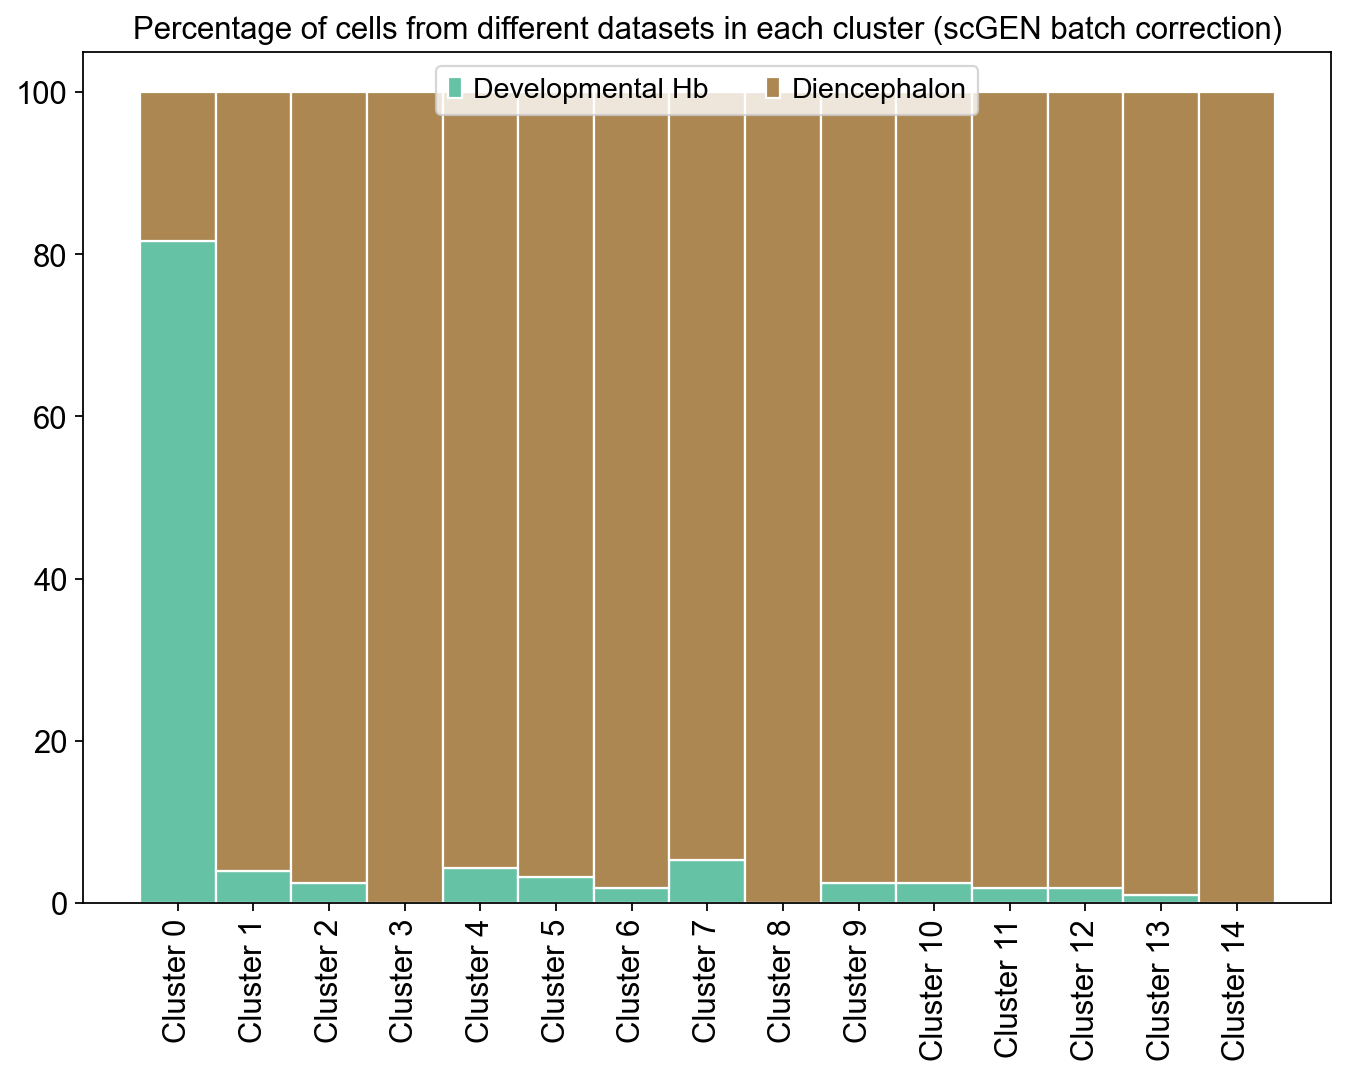

In [76]:
plt.figure(figsize=(10, 7))
een = plt.bar(df.columns, df.loc["Developmental Hb"], edgecolor="white", width=1, color="#66c2a5")
twee = plt.bar(df.columns, df.loc["Diencephalon"], bottom=df.loc["Developmental Hb"], edgecolor="white", width=1, color="#ac8751")
plt.legend((een[0], twee[0]), ("Developmental Hb", "Diencephalon"), loc="upper center", ncol=2)
plt.xticks(rotation=90)
plt.title("Percentage of cells from different datasets in each cluster (scGEN batch correction)")
plt.grid(False)
plt.savefig("../../../figures/MergedIntegration/SimpleMerge/cell_distribution_clusters_scgen.png")
plt.show()